In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import math

In [3]:
train = pd.read_csv('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/test.csv')

In [4]:
test.head()

,ID,Image
0,1,D3_693.jpg
1,2,D3_212.jpg
2,3,D3_724.jpg
3,4,D3_623.jpg
4,5,D3_210.jpg


In [5]:
NUM_CLASSES = 2
FRAME_WIDTH = 255
FRAME_HEIGHT = 255
BATCH_SIZE = 32

In [6]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(FRAME_HEIGHT, FRAME_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Define a custom generator
def custom_image_generator(dataframe, BATCH_SIZE, isTrain):
    num_samples = len(dataframe)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, BATCH_SIZE):
            batch_indices = indices[i:i+BATCH_SIZE]
            batch_data = dataframe.iloc[batch_indices]
            batch_images = []
            batch_labels = batch_data['Class'].values.tolist()

            for _, row in batch_data.iterrows():
                if isTrain:
                    image_path = '/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/train/'
                else:
                    image_path = '/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/test/'
                image_path += row['Image']
                img = load_and_preprocess_image(image_path)
                batch_images.append(img)

            yield np.array(batch_images), np.array(batch_labels)


train_generator = custom_image_generator(train, BATCH_SIZE, True)
validation_generator = custom_image_generator(val, BATCH_SIZE,True)
validation_generator2 = custom_image_generator(val, BATCH_SIZE,True)


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Define a directory to save the model checkpoints
checkpoint_dir = '/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/model_checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_weights_vgg.h5'),  # Save with epoch number
    save_best_only=False,  # Save model weights after each epoch
    save_weights_only=True,  # Save only the weights, not the entire model
    verbose=1  # Display progress during saving
)

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True
end_callback = myCallback()


Using VGG 16 layer CNN

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Reshape
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(FRAME_HEIGHT, FRAME_WIDTH, 3))
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
# Create a custom top classifier
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model using fit_generator
history =model.fit(
    train_generator,
    steps_per_epoch=math.ceil(len(train) // BATCH_SIZE),  # Adjust this as needed
    epochs=7,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=math.ceil(len(val) // BATCH_SIZE),  # Adjust this as needed
    callbacks=[checkpoint_callback, end_callback])

test_loss, test_accuracy = model.evaluate(validation_generator2, steps=math.ceil(len(val) // BATCH_SIZE))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
file1 = open('accuracy.txt', 'w')
file1.write(f'Test accuracy: {test_accuracy * 100:.2f}%')
file1.close()
model.save('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/model_checkpoints/embryoclassification.h5')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/7
21/21 [==============================] - ETA: 0s - loss: 1.4181 - accuracy: 0.8244 
Epoch 1: saving model to /content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/model_checkpoints/model_weights_vgg.h5
21/21 [==============================] - 378s 18s/step - loss: 1.4181 - accuracy: 0.8244 - val_loss: 0.4444 - val_accuracy: 0.8938
Epoch 2/7
21/21 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8780
Epoch 2: saving model to /content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/model_checkpoints/model_weights_vgg.h5
21/21 [==============================] - 5s 246ms/step - loss: 0.4041 - accuracy: 0.8780 - val_loss: 0.3213 - val_accuracy: 0.9000
Epoch 3/7
21/21 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9167
Epoch 3: saving model to /content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
test_images = []
for _, row in test.iterrows():

    image_path = '/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/test/'
    image_path += row['Image']
    img = load_and_preprocess_image(image_path)
    test_images.append(img)

test_images = np.array(test_images)
test_images.shape

(180, 255, 255, 3)

In [11]:
predicted = model.predict(test_images, steps=math.ceil(len(test) / BATCH_SIZE))

6/6 [==============================] - 8s 131ms/step


In [12]:
pred_df = pd.DataFrame(data=None, columns = ['ID', 'Class'])
for i in predicted:
    iinx = np.argmax(i)
    pred_df.loc[len(pred_df.index)] = [ len(pred_df.index)+1, iinx]
pred_df.to_csv('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/vggoutput.csv', index=False)

In [13]:
predicted_classes = []
test_image_names = []

for _, row in test.iterrows():
    image_path = '/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/test/'
    image_path += row['Image']

    img = load_and_preprocess_image(image_path)
    prediction = model.predict(np.array([img]))
    predicted_class = np.argmax(prediction, axis=1)

    test_image_names.append(row['Image'])
    predicted_classes.append(predicted_class[0])  # Assuming single class prediction

# Create a DataFrame to display test image names and their predicted classes
results = pd.DataFrame({'Image': test_image_names, 'Predicted_Class': predicted_classes})
print(results)


1/1 [==============================] - 0s 25ms/step
          Image  Predicted_Class
0    D3_693.jpg                0
1    D3_212.jpg                1
2    D3_724.jpg                0
3    D3_623.jpg                0
4    D3_210.jpg                0
..          ...              ...
175  D5_020.jpg                1
176  D5_133.jpg                0
177  D5_119.jpg                1
178  D5_322.jpg                0
179  D5_017.jpg                1

[180 rows x 2 columns]


In [14]:
predicted_class_1 = results[results['Predicted_Class'] == 1]

# Display the images where the predicted class is 1
print(predicted_class_1)

          Image  Predicted_Class
1    D3_212.jpg                1
76   D3_791.jpg                1
124  D5_248.jpg                1
126  D5_073.jpg                1
127  D5_275.jpg                1
130  D5_159.jpg                1
132  D5_330.jpg                1
133  D5_370.jpg                1
134  D5_388.jpg                1
135  D5_181.jpg                1
137  D5_047.jpg                1
139  D5_149.jpg                1
144  D5_221.jpg                1
155  D5_008.jpg                1
159  D5_281.jpg                1
160  D5_339.jpg                1
171  D5_282.jpg                1
175  D5_020.jpg                1
177  D5_119.jpg                1
179  D5_017.jpg                1


In [15]:
from google.colab import files

# Prompt the user to upload files
uploaded = files.upload()

# Save the uploaded file(s)
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    image_path = filename  # Path to the uploaded file
    img = load_and_preprocess_image(image_path)

    # Reshape the image to match the model's input shape if necessary
    # img = img.reshape(desired_shape)  # Uncomment and adjust if needed

    # Make predictions
    predictions = model.predict(np.array([img]))

    # Assuming it's a classification task, get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    # Print the predicted class
    print("Predicted class:", predicted_class)


Saving D5_017.jpg to D5_017.jpg
Uploaded file: D5_017.jpg
1/1 [==============================] - 0s 19ms/step
Predicted class: [1]


In [16]:
from google.colab import files
from tensorflow.keras.models import load_model



Pred_model = load_model('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/model_checkpoints/embryoclassification.h5')

# Prompt the user to upload files
uploaded = files.upload()

# Save the uploaded file(s)
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    image_path = filename  # Path to the uploaded file
    img = load_and_preprocess_image(image_path)

    # Reshape the image to match the model's input shape if necessary
    # img = img.reshape(desired_shape)  # Uncomment and adjust if needed

    # Make predictions
    predictions = Pred_model.predict(np.array([img]))

    # Assuming it's a classification task, get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    # Print the predicted class
    print("Predicted class:", predicted_class)




Saving D5_221.jpg to D5_221.jpg
Uploaded file: D5_221.jpg
1/1 [==============================] - 0s 146ms/step
Predicted class: [1]


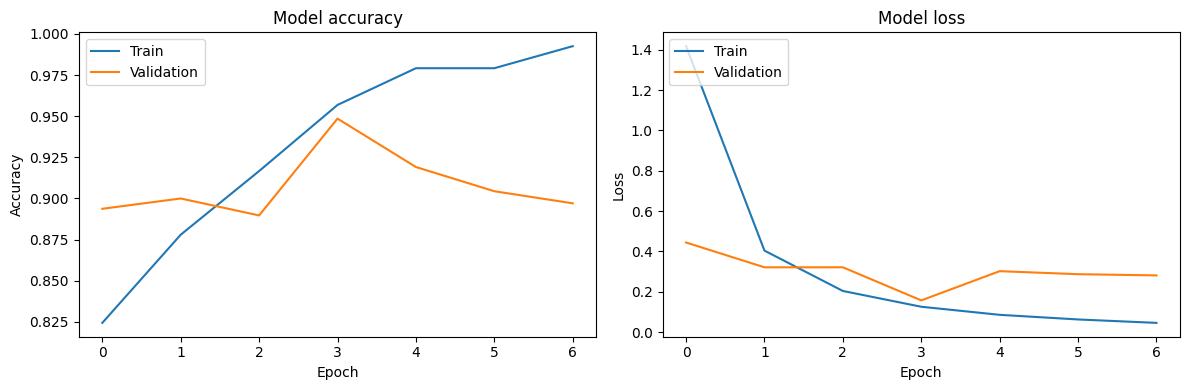

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plotting loss and accuracy graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

# Save the figure
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/loss_and_accuracy.png')
plt.show()




1/1 [==============================] - 0s 37ms/step


<Figure size 800x600 with 0 Axes>

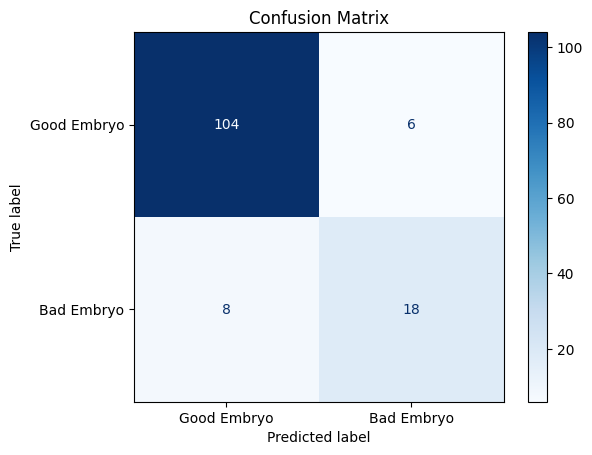

In [21]:
# Generate predictions and collect true labels
y_true = []
y_pred = []

for i in range(math.ceil(len(val) // BATCH_SIZE)):
    batch_images, batch_labels = next(validation_generator2)
    preds = model.predict(batch_images)
    y_true.extend(batch_labels)
    y_pred.extend(preds.argmax(axis=1))

# Convert lists to numpy arrays
import numpy as np
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
labels = ['Good Embryo', 'Bad Embryo']  # Update with your class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save the confusion matrix figure
plt.savefig('/content/drive/MyDrive/AIS_BE_Projects/AIS_Embryo_Project/Embryo_classification /hvwc23/confusion_matrix.png')
plt.show()
